In [1]:
import numpy as np
from imp import reload
from keras.layers import * # YL
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping

# ============== DL ===============================
# Limit GPU memory(VRAM) usage in TensorFlow 2.0
# https://github.com/tensorflow/tensorflow/issues/34355
# https://medium.com/@starriet87/tensorflow-2-0-wanna-limit-gpu-memory-10ad474e2528

import tensorflow as tf

# ---- Method 1 ----
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
# ============== DL ===============================
from utility.helper import psnr, load_imgs, image_to_block, regroup, save_imgs, performance_evaluation
from utility.parameter import *

import coarse.train as coarse_train
import coarse.test as coarse_test
import prediction.train as prediction_train
import prediction.inference as prediction_inference
import residue.train as residue_train 
import residue.inference as residue_inference

# ============== DL ===============================
# Default is 1e-7 which is too small for float16.  
# Without adjusting the epsilon, we will get NaN predictions because of divide by zero problems
import keras.backend as K
if rtx_optimizer == True:
    K.set_epsilon(1e-4) 
# =================================================

b = 16 # blk_size
bm = 8 # target block size to predict

train_images = load_imgs(data_dir, train_start, train_end) 
test_images = load_imgs(data_dir, test_start, test_end)

Using TensorFlow backend.


In [2]:
# from utility.helper import get_block_set

# prev = get_block_set(1, train_images, 16, 8, 0)
# new_prev = image_to_block(train_images[0:], 16, True)
# import numpy as np
# print(np.array_equal(prev.astype('uint8'), new_prev.astype('uint8')))

# from matplotlib import pyplot as plt
# _, axs = plt.subplots(2, 5)
# for i in range(2): 
#     for j in range (5):
#         axs[i, j].imshow(prev[i*52+j])

In [3]:
# _, axs2 = plt.subplots(2, 5)
# for i in range(2): 
#     for j in range (5):
#         axs2[i, j].imshow(new_prev[i*52+j])

In [4]:
# # ==== coarse train ====
# # coarse.train.model(train_images, b, training_ratio)

# # ==== prediction train ====
# decoded = coarse_test.predict(train_images, b, training_ratio)

# # prediction_train.model(train_images, decoded, b, bm, training_ratio)

# # ==== residue train ====
# regrouped_prediction = prediction_inference.predict(decoded, b, bm, training_ratio, "prediction_gnet6")

# residue_train_images = train_images[1:n_train_frames-1]
# residue = residue_train_images - regrouped_prediction
# residue_train.model(residue, b, training_ratio)

In [5]:
# =================================================
decoded = coarse_test.predict(test_images, b, testing_ratio)

# start, step = 0, 1
# n2_evaluated, coarse_amse, coarse_apsnr, coarse_assim = performance_evaluation(test_images, decoded, start, step)
# print('n_evaluated:',n2_evaluated)
# print('average test coarse_amse:',coarse_amse)
# print('average test coarse_apsnr:',coarse_apsnr)
# print('average test coarse_assim:',coarse_assim)

Loaded model from C:/Users/danni/Documents/GitHub/SPIEcode-Daniel/models/BlowingBubbles_416x240_50/6/hdf5/coarse.hdf5
n_evaluated: 100
average test coarse_amse: 41.540043068910265
average test coarse_apsnr: 31.95410917201805
average test coarse_assim: 0.8497131680551274


In [6]:
residue_test_images = test_images[1:-1]
regrouped_prediction = prediction_inference.predict(decoded, 16, 8, testing_ratio, "prediction")

# start, step = 0, 1
# n0_evaluated, pred_amse, pred_apsnr, pred_assim = performance_evaluation(residue_test_images, regrouped_prediction, start, step)
# print('n0_evaluated:',n0_evaluated)
# print('average test pred_amse:',pred_amse)
# print('average test pred_apsnr:',pred_apsnr)
# print('average test pred_assim:',pred_assim)

Loaded model from C:/Users/danni/Documents/GitHub/SPIEcode-Daniel/models/BlowingBubbles_416x240_50/6/hdf5/prediction.hdf5
n0_evaluated: 98
average test pred_amse: 49.83638961794653
average test pred_apsnr: 31.16917405450316
average test pred_assim: 0.7904163168171461


In [7]:
residue = residue_test_images - regrouped_prediction
residue_predicted_frames = residue_inference.predict(residue, b, testing_ratio)
final_frame = np.add(regrouped_prediction, residue_predicted_frames)

# start, step = 0, 1
# n_evaluated, pred_res_amse, pred_res_apsnr, pred_res_assim = performance_evaluation(residue_test_images, final_frame, start, step)
# print('n_evaluated:',n_evaluated)
# print('average test pred_res_amse:',pred_res_amse)
# print('average test pred_res_apsnr:',pred_res_apsnr)
# print('average test pred_res_assim:',pred_res_assim)

Loaded model from C:/Users/danni/Documents/GitHub/SPIEcode-Daniel/models/BlowingBubbles_416x240_50/6/hdf5/residue.hdf5
n_evaluated: 98
average test pred_res_amse: 39.08695422880691
average test pred_res_apsnr: 32.22943733911276
average test pred_res_assim: 0.8573432654760724


In [8]:
# print('average test overall_amse:', (pred_res_amse+coarse_amse)/2.0)
# print('average test overall_apsnr:', (pred_res_apsnr+coarse_apsnr)/2.0)
# print('average test overall_assim:', (pred_res_assim+coarse_assim)/2.0)

In [9]:
a = decoded[1:-1].flatten()
b = regrouped_prediction.flatten()
c = final_frame.flatten()

In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

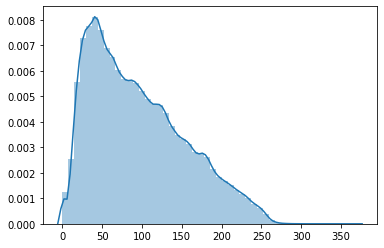

In [11]:
sns.distplot(a);

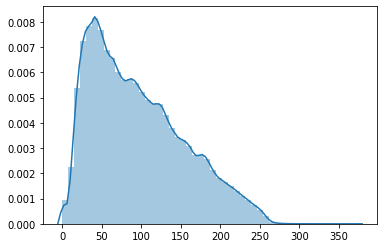

In [12]:
sns.distplot(b);

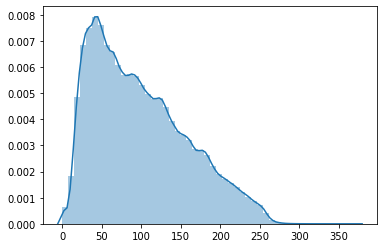

In [13]:
sns.distplot(c);